# Motor vehicle accidents in Victoria from 2011 to 2012: an investigation into accident remediation

Author: Rhys Whitley \\\\
Date: 24 June 2016 \\\\ PwC Case Study

In [1]:
# allows plots to be displayed in the notebook
%matplotlib inline

In [2]:
# load python libraries for visualisation and analysis
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap

## Data import: load and clean dataset

In [3]:
FILENAME = "Dataset A - Road Accident Data.xlsx"
FILEPATH = os.path.expanduser("~/Documents/Code/Python/PwC_casestudy/") + FILENAME
if os.path.isfile(FILEPATH):
    print(">> FILE FOUND: {0}".format(FILENAME))
else:
    print(">> FILE NOT FOUND")

>> FILE FOUND: Dataset A - Road Accident Data.xlsx


Using Pandas, load the excel file that contains the data and print the metadata for the file

In [4]:
roads = pd.read_excel(FILEPATH)
roads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25484 entries, 0 to 25483
Data columns (total 34 columns):
ACCIDENT_NO                         25484 non-null object
ACCIDENT_DATE                       25484 non-null datetime64[ns]
ACCIDENT_TIME                       25484 non-null object
ACCIDENT_DESCRIPTION                25484 non-null object
DCA_CODE_DESCRIPTION                25484 non-null object
DCA_CODE_TYPE                       25484 non-null object
LIGHT_CONDITION_DESCRIPTION         25484 non-null object
NO_PERSONS_INVOLVED                 25484 non-null int64
NO_PERSONS_KILLED                   25484 non-null int64
NO_PERSONS_INJ_SERIOUS              25484 non-null int64
NO_PERSONS_INJ_MEDICAL_ATTENTION    25484 non-null int64
NO_PERSONS_NOT_INJ                  25484 non-null int64
NO_OF_VEHICLES                      25484 non-null int64
POLICE_ATTEND_DESCRIPTION           25484 non-null object
ROAD_GEOMETRY_DESCRIPTION           25484 non-null object
SEVERITY           

I'm going to shorten the titles of some of these columns so the plotting is easier to read and there is less for me to write.

In [5]:
col1 = [rc.replace("RIPTION", "") for rc in roads.columns]
col2 = [rc.replace("NO_PERSONS", "NP") for rc in col1]
roads.columns = col2

Let us do some quick exploration of the data and come up with some questions we can easily 
answer using the Python analysis libraries. But first we need to split the datasets into both
numeric and factor (or categorical) components so that we can aggregate the data properly.

First of all, let us find which columns are numeric that we can possibly aggregate on.

In [6]:
# numeric columns that can be aggregated on
roads_numeric = roads.select_dtypes(include=['float64', 'int64'])
roads_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25484 entries, 0 to 25483
Data columns (total 11 columns):
NP_INVOLVED                 25484 non-null int64
NP_KILLED                   25484 non-null int64
NP_INJ_SERIOUS              25484 non-null int64
NP_INJ_MEDICAL_ATTENTION    25484 non-null int64
NP_NOT_INJ                  25484 non-null int64
NO_OF_VEHICLES              25484 non-null int64
SEVERITY                    25484 non-null int64
SPEED_ZONE                  25484 non-null int64
LON                         25484 non-null float64
LAT                         25484 non-null float64
GRID_REFERENCE_Y            25484 non-null int64
dtypes: float64(2), int64(9)
memory usage: 2.1 MB


Only some of these numeric columns can be truly aggregated on, the others are closer to categorical columns.
My assumption is that any columns with the leading title of NO\_ will provide numeric data that can be aggregated on. 

So lets collect those column titles from the main dataframe that suggest discrete measurements.

In [7]:
# use a list comprehension with some regex
num_search = r'(^NP_.*)'
numeric_cols = [clab for clab in roads.columns if re.search(num_search, clab)]
print(numeric_cols)

['NP_INVOLVED', 'NP_KILLED', 'NP_INJ_SERIOUS', 'NP_INJ_MEDICAL_ATTENTION', 'NP_NOT_INJ']


For convenience I'm going to combine the DATE and TIME records into a Pandas timestamp object that
can be used for aggregation and resampling. This will make the data easier to work with.

In [8]:
roads['DT'] = [pd.to_datetime("{0} {1}".format(d, t)) \
                 for (d, t) in np.array(roads.ix[:, ['ACCIDENT_DATE', 'ACCIDENT_TIME']])]
roads.set_index(['DT'], inplace=True)

I've created an extra index that describes the degree of attrition (to the general public) using a ratio of people hurt/killed to the total number of people involved. However, this ratio will not scale with the dataset given that the measurements are discretised, not continuous.

I've therefore added a lambda function to quickly determine a scaled calculation of the roads attriation ratio at various aggregated levels.

In [9]:
# determin the rate of attrition for each record
attrition_cols = numeric_cols[1:-1]
roads["TOTAL_ATTRIT"] = roads.ix[:, attrition_cols].sum(axis=1)

# a quick function that can be applied at various aggregated levels of the dataset
attrit_ratio = lambda df: df["TOTAL_ATTRIT"]/df[numeric_cols[0]]

# determine the base attrition ratio
roads["RATIO_ATTRIT"] = attrit_ratio(roads)

# we will also include the new total roads attrition column
numeric_cols2 = numeric_cols + ["TOTAL_ATTRIT"]

Determine whether the measurement occured during the weekend or during the week from the date-time index. 

In [10]:
roads['WEEKEND'] = ['NO' if dt.dayofweek < 5 else 'YES' for dt in roads.index]

[*optional] Also add whether the accident was on a public holiday (dates extracted from http://www.afei.org.au/)

In [11]:
hold_dates = ['2011-01-03', '2011-01-26', '2011-03-14', '2011-04-22', '2011-04-25', '2011-04-26', \
              '2011-06-13', '2011-11-01', '2011-12-25', '2011-12-26', '2011-12-27', \
              '2012-01-01', '2012-01-02', '2012-01-26', '2012-03-12', '2012-04-06', '2012-04-09', \
              '2012-04-25', '2012-06-11', '2012-11-06', '2012-12-25', '2012-12-26']
roads['PUBLIC_HOL'] = ['YES' if dt in [pd.to_datetime(h) for h in hold_dates] else 'NO' for dt in roads.index]

## Spatial data viz on road accidents

We're going to start by exploring the data on a basemap image using the geo-coordiantes provided in the dataset. Below are a couple of functions that make plotting less verbose and allow us to plot the categorical features of the dataset onto the map. 

*Feel free to use these in your own projects, just make sure to alter those specific lines that are hardwired to this dataset*

In [230]:
def victoria_map(ax_0):
    """Generic plotting function to create maps of victoria that we can plot data on"""

    with sns.axes_style(rc={'axes.facecolor':'gray', 'figure.facecolor':'white'}):
        # create a basemap to plot on
        map_ = Basemap(llcrnrlon=141, llcrnrlat=-39.5, urcrnrlon=150, urcrnrlat=-34, \
                  projection='merc', resolution='i', ax=ax_0)  
        # colour it in
        map_.drawmapboundary(fill_color='gray', zorder=0)
        map_.fillcontinents(color='white',lake_color='gray', zorder=0)
        map_.drawcoastlines()
        map_.drawmapboundary()
        map_.drawparallels(np.arange(-90, 90, 1), color='white', labels=[1, 0, 0, 0], zorder=0)
        map_.drawmeridians(np.arange(0, 360, 1), color='white', labels=[0, 0, 0, 1], zorder=0)
    
    return map_

def region_map(ax_0, data):
    """Generic plotting function to create maps of victoria that we can plot data on"""

    with sns.axes_style(rc={'axes.facecolor':'gray', 'figure.facecolor':'white'}):
        # create a basemap to plot on
        map_ = Basemap(llcrnrlon=min(data['LON']), llcrnrlat=min(data['LAT']), 
                       urcrnrlon=max(data['LON']), urcrnrlat=max(data['LAT']), \
                  projection='merc', resolution='h', ax=ax_0)  
        # colour it in
        map_.drawmapboundary(fill_color='gray', zorder=0)
        map_.fillcontinents(color='white',lake_color='gray', zorder=0)
        map_.drawcoastlines()
        map_.drawmapboundary()
        map_.drawparallels(np.arange(-90, 90, 0.2), color='white', labels=[1, 0, 0, 0], zorder=0)
        map_.drawmeridians(np.arange(0, 360, 0.2), color='white', labels=[0, 0, 0, 1], zorder=0)
    
    return map_

def plot_feature(vic_map, data, label1, fontsize=14):
    lab1_tag = list(set(data[label1]))
    feature1 = data[label1].astype('category').cat.codes.values
    # set colors
    n_colors = len(lab1_tag)
    my_cmap = cm.get_cmap('Set1', n_colors)
    
    # actual plotting
    x, y = vic_map(data['LON'].values, data['LAT'].values)
    vic_map.scatter(x, y, marker='o', c=feature1, cmap=my_cmap, alpha=0.5)
    
    # legend magic
    get_circ = lambda x: Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=x)   
    circ_handle = [get_circ(my_cmap(c)) for c in range(n_colors)]
    plt.legend(handles=circ_handle, labels=lab1_tag, fontsize=fontsize, title=label1)
    return None

def plot_feature2x(vic_map, data, label1, label2, fontsize=14):
    lab1_tag = list(set(data[label1]))
    lab2_tag = list(set(data[label2]))
    feature1 = data[label1].astype('category').cat.codes.values
    feature2 = data[label2].astype('category').cat.codes.values
    # set colors
    n_colors = len(lab1_tag)
    my_cmap = cm.get_cmap('Set1', n_colors)
    
    # actual plotting
    x, y = vic_map(data['LON'].values, data['LAT'].values)
    my_norm = lambda xx: 1 - (xx-xx.min(axis=0))/(xx.max(axis=0)-xx.min(axis=0))
    feat_size = np.maximum(my_norm(feature2), 0.1)*40
    vic_map.scatter(x, y, marker='o', c=feature1, s=feat_size, cmap=my_cmap, alpha=0.5)
    
    # legend magic
    get_circ = lambda x: Line2D(range(1), range(1), color="white", markersize=15, marker='o', markerfacecolor=x)   
    circ_handle = [get_circ(my_cmap(c)) for c in range(n_colors)]
    plt.legend(handles=circ_handle, labels=sorted(lab1_tag), fontsize=fontsize, title=label1)

    return None

In [ ]:
fig = plt.figure(figsize=(18, 18))
rog = list(set(roads['REGION_NAME']))
mel_roads = roads[roads['DIRECTORY']=='MEL']
ax = plt.subplot(111)
mel_map = region_map(ax, mel_roads)
plot_feature2x(mel_map, mel_roads, "LOCALS_INVOLVED", "SEVERITY", fontsize=20)

Lets plot a map of accidents according to the severity and colour code the map according to the different regions.

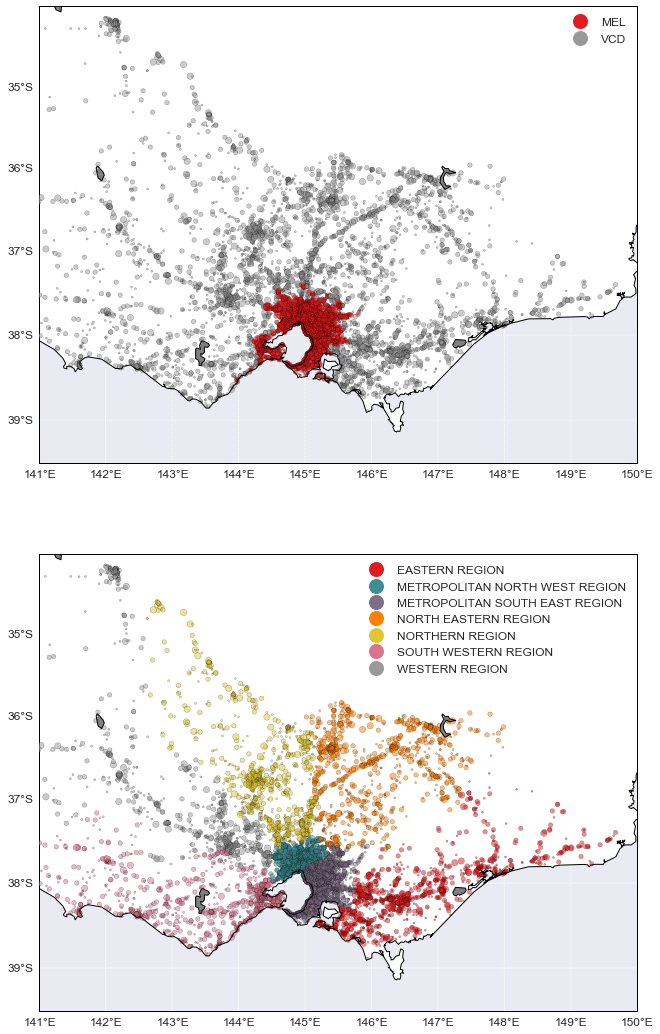

In [17]:
fig = plt.figure(figsize=(18, 18))

feats_list = ["DIRECTORY", "REGION_NAME"]
gs = gridspec.GridSpec(len(feats_list), 1)

for (i, feature) in enumerate(feats_list):
    # spatial map
    ax1 = plt.subplot(gs[i])
    vic_map = victoria_map(ax1)
    plot_feature2x(vic_map, roads, feature, "SEVERITY", fontsize=12)


Unsurprisingly, most of the accidents have the highest density around the major urban regions - I've used transparency to help visualise the density of points. However, severity (indicated by the size of the cirles) appears to be rather uniformely spread.

Just to help identify whether there are any particular geographics patterns I've plotted the number of occurences for **accident SEVERITY**, and split these between metropolitan and regional, in addtion the sub-regions.

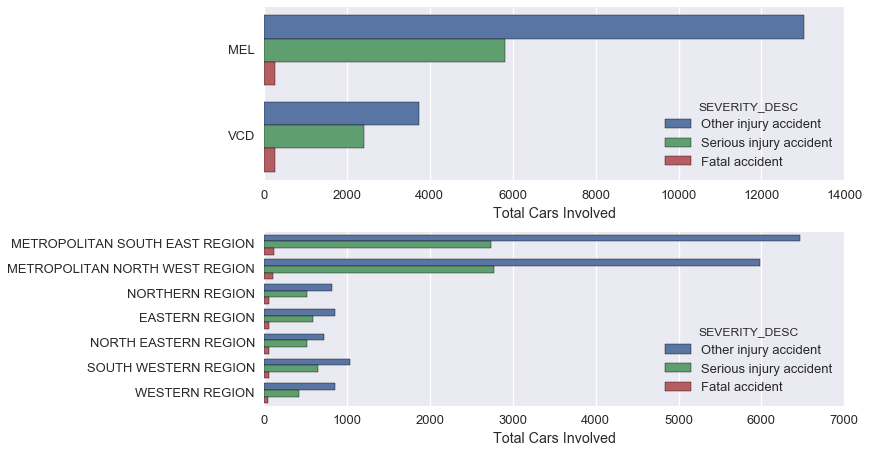

In [311]:
#sns.set_style('white')
sns.set_context("talk")

feats_list = ["DIRECTORY", "REGION_NAME"]
gs = gridspec.GridSpec(len(feats_list), 1, hspace=0.3)

for (i, feature) in enumerate(feats_list):
    ax2 = plt.subplot(gs[i])
    g = sns.countplot(y=feature, hue="SEVERITY_DESC", data=roads, ax=ax2)
    g.set(xlabel='Total Cars Involved', ylabel='')

Our top figure split between Melbourne and regional Victoria, shows that there is little difference between the two for fatal accidents. However, there are larger differences for serious injury and in the case of **other injury accidents** the difference is very large. Splitting the data up in terms of the sub-regions shows the same pattern of the proportion of metropolitan accidents are much larger than region accidents.

An obvious reason for this is likely due to a **greater density of vehicles** moving around the metropolitan region compared to regional districts. We can quickly show this to be true by plotting the number of cars involved in accidents.


Total cars involved in accidents from 2011-2012: 45844


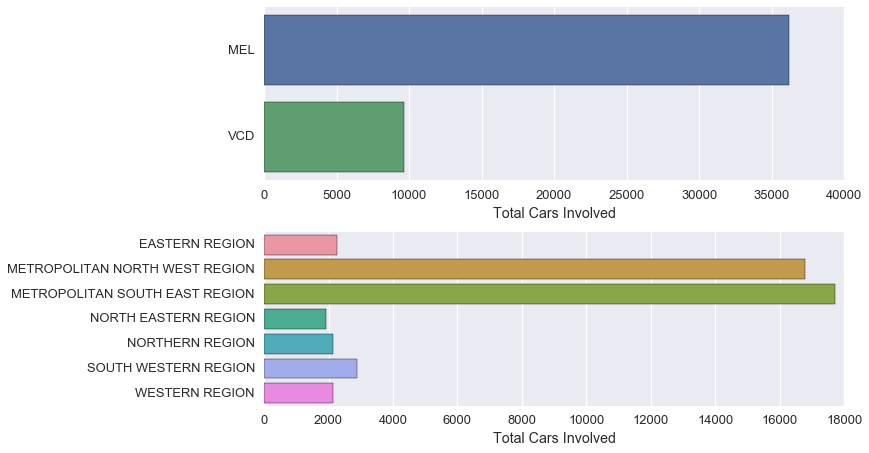

In [310]:
#sns.set_style('white')
sns.set_context("talk")

print("\nTotal cars involved in accidents from 2011-2012: {0}".format(roads.NO_OF_VEHICLES.sum()))

feats_list = ["DIRECTORY", "REGION_NAME"]
subdata = roads[feats_list + ["NO_OF_VEHICLES"]].groupby(feats_list).sum()

gs = gridspec.GridSpec(len(feats_list), 1, hspace=0.3)

for (i, feature) in enumerate(feats_list):
    ax2 = plt.subplot(gs[i])
    subdata = roads[[feature] + ["NO_OF_VEHICLES"]].groupby(feature).sum()
    g = sns.barplot(y=feature, x="NO_OF_VEHICLES", data=subdata.reset_index(), ax=ax2)
    g.set(xlabel='Total Cars Involved', ylabel='')

Do specific local governemnt agencies have more accidents occuring in their boundaries than others?

In [305]:
lga_subset = roads[['LGA_NAME','ACCIDENT_NO']].groupby(['LGA_NAME']).count()
lga_total = lga_subset.reset_index().sort_values(['ACCIDENT_NO'], ascending=False)
lga_top = lga_total.head(10) #[lga_total['ACCIDENT_NO'] > 600]

roads_lga = roads[roads['LGA_NAME'].isin(lga_top['LGA_NAME'])]

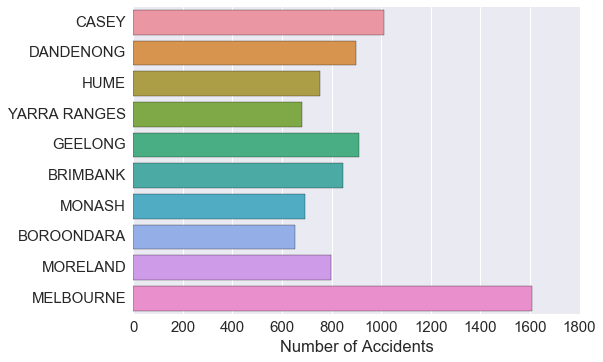

In [316]:
#plt.figure(figsize=(12, 12));
sns.set(font_scale=1.5)
sns.countplot(y="LGA_NAME", data=roads_lga)
sns.axlabel('Number of Accidents', '')

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(111)
subdata = roads_lga[roads_lga.LGA_NAME == "MELBOURNE"]
map_1 = region_map(ax1, subdata)
plot_feature(map_1, subdata, "DCA_CODE_TYPE", fontsize=12)

#lga_list = lga_top['LGA_NAME'].values
#gs = gridspec.GridSpec(5, 2)

#for (i, feature) in enumerate(lga_list):
#    subdata = roads_lga[roads_lga['LGA_NAME'] == feature]
#    # spatial map
#    ax1 = plt.subplot(gs[i])
#    map_ = region_map(ax1, subdata)
#    plot_feature2x(map_, subdata, "ROAD_GEOMETRY_DESC", "SEVERITY", fontsize=12)

## Does level of lighting or time of day have an impact on the number of accidents?

A plot of the total number of accidents in terms of the lighting conditions for the road at the time shows the majority of accidents are occuring during the day. Even if one were to add up the all the dark categories, they would still be less than half of day accidents.

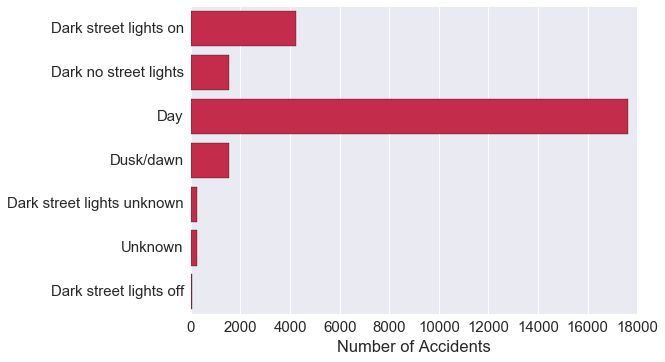

In [20]:
sns.set(font_scale=1.5)
sns.countplot(y="LIGHT_CONDITION_DESC", data=roads, color='crimson')
sns.axlabel('Number of Accidents', '')

There also appears to be no region specific differences for accidents occuring under different the light conditions. For all regions, the majority of accidents are occuring during the day.

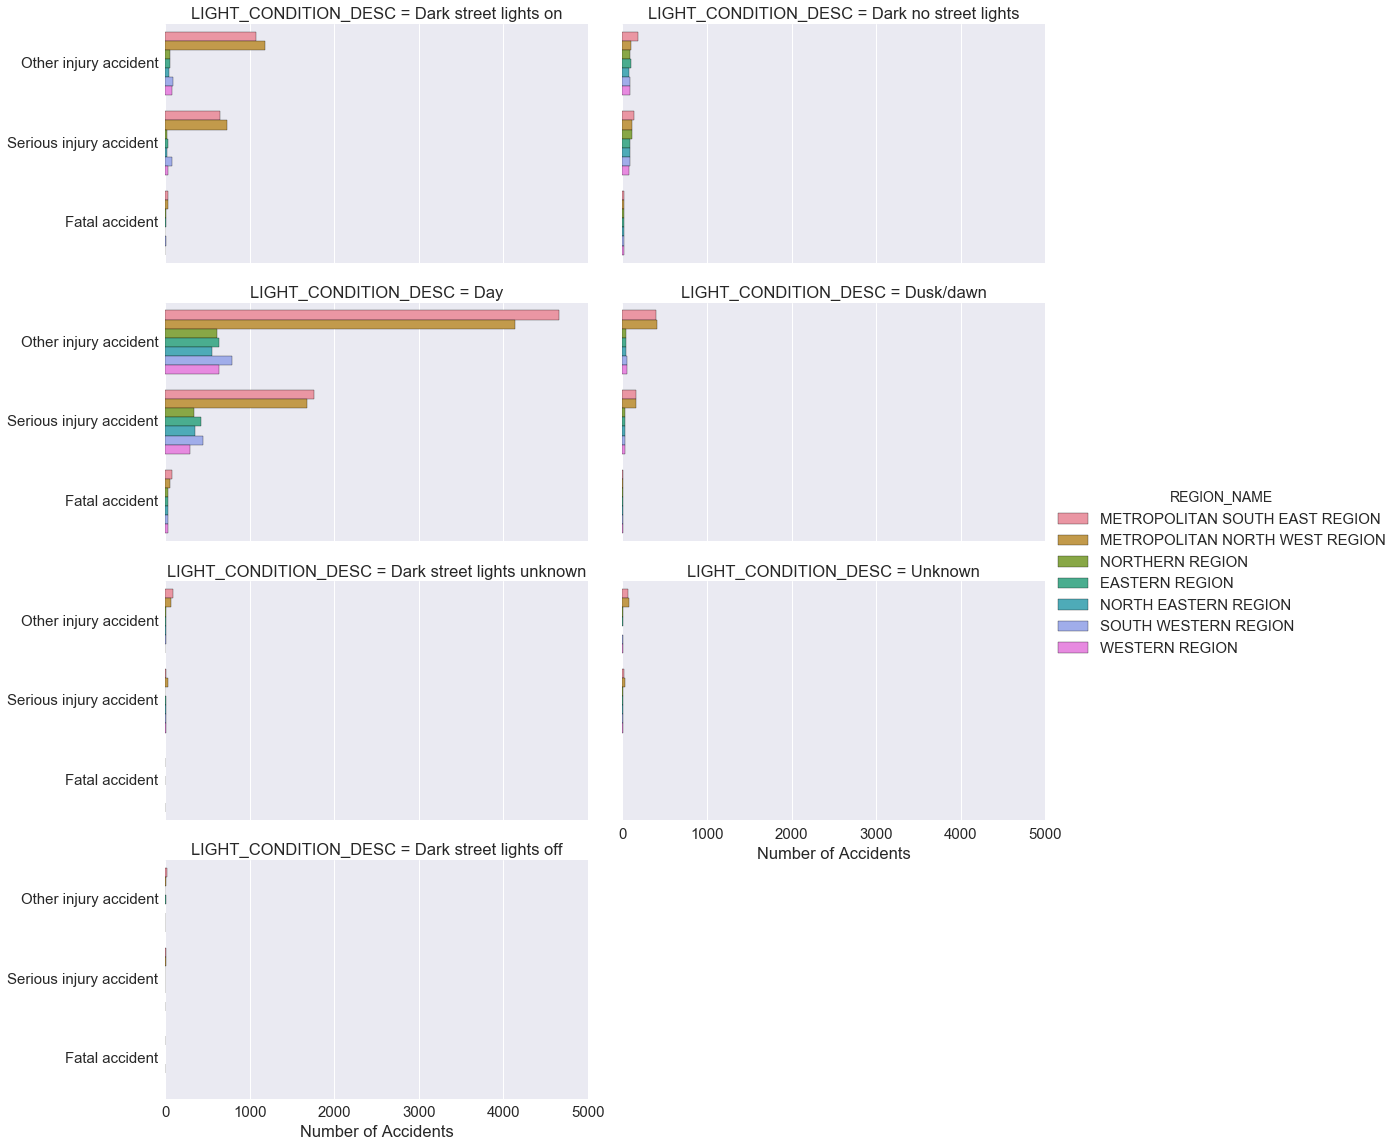

In [50]:
plt.figure(figsize=(12, 12));

sns.set(font_scale=1.5);
g = sns.factorplot(y="SEVERITY_DESC", col="LIGHT_CONDITION_DESC", hue='REGION_NAME', 
               kind='count', data=roads, col_wrap=2, aspect=2);
g.set_axis_labels('Number of Accidents', '');

We can do a quick plot of the number of accidents that occur under different lighting conditions. First let's look at the time of day and see what this yields. 

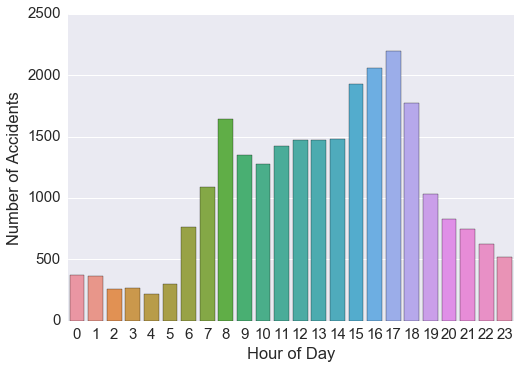

In [57]:
group_these = ['DIRECTORY', 'WEEKEND', roads.index.hour]
roads_time = roads.groupby(group_these[2]).count()

sns.set(font_scale=1.5)
sns.barplot(y='ACCIDENT_NO', x='index', 
            data=roads_time.reset_index())
sns.axlabel('Hour of Day', 'Number of Accidents')

So visually we can see that the majority of accidents are occuring during the day, and the bi-model nature of the distribution suggests that a large proportion of accidents are occuring at two peak periods. The first is in the morning at approximately 8AM which denotes the morning peak period, and the second occurs during the afternoon peak period from 3PM (school pickup) until 6PM (leaving work).

We can examine this further by splitting the data up according to weekend or weekday, as well as metropolitan and region areas. The morning and afternoon peaks remain for Melbourne during week, but flatten out over the weekend when there are less cars on the road and there is no group imperative to be at common places. Acknowledging that there is a lower density of cars on the road in regional areas, Regional Victoria also shows morning and afternoon peaks during the week, but flattens out over the weekend.

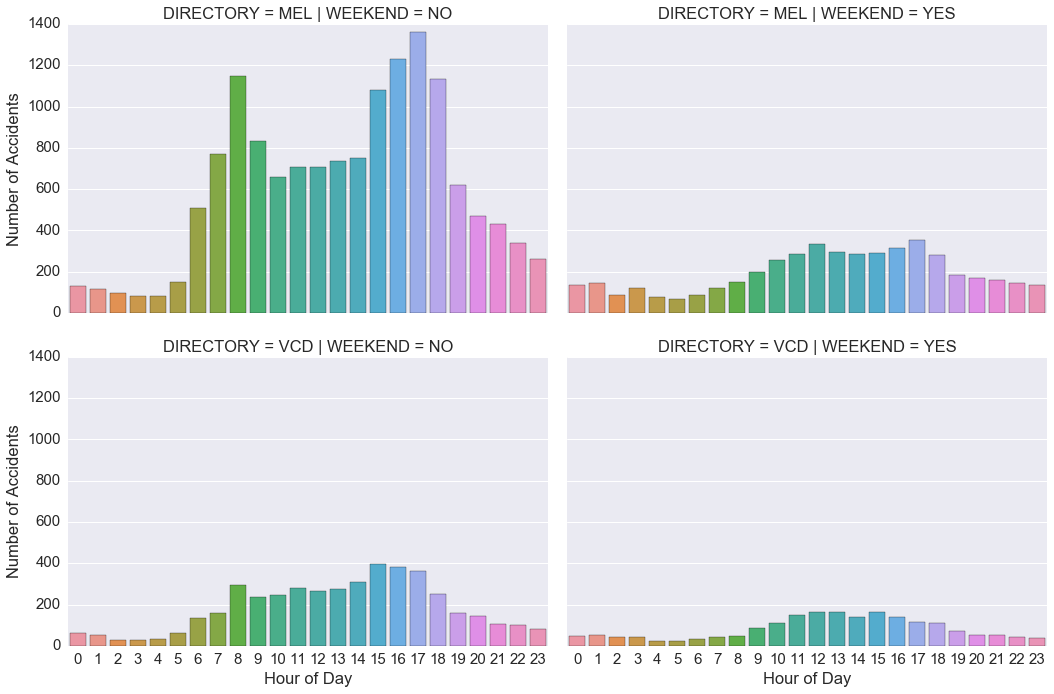

In [107]:
group_these = ['DIRECTORY', 'WEEKEND', roads.index.hour]
roads_time_we = roads.groupby(group_these).count()

sns.set(font_scale=1.5)
g = sns.factorplot(y='ACCIDENT_NO', x='level_{0}'.format(len(group_these)-1), 
                col='WEEKEND', kind='bar',row='DIRECTORY', size=5, aspect=1.5,
                data=roads_time_we.reset_index())
g.set_axis_labels('Hour of Day', 'Number of Accidents')

We can also cross check this with the number of cars on the road, during these periods.

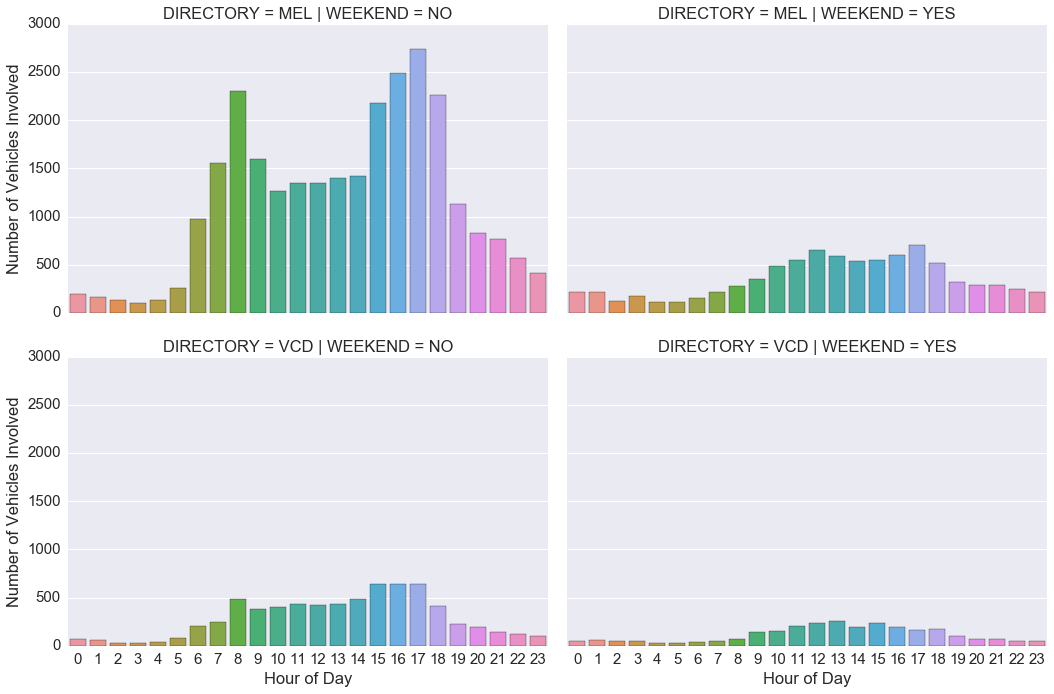

In [63]:
group_these = ['DIRECTORY', 'WEEKEND', roads.index.hour]
roads_time_car = roads.groupby(group_these).sum()

sns.set(font_scale=1.5)
g = sns.factorplot(y='NO_OF_VEHICLES', x='level_{0}'.format(len(group_these)-1), 
                col='WEEKEND', kind='bar',row='DIRECTORY', size=5, aspect=1.5,
                data=roads_time_car.reset_index())
g.set_axis_labels('Hour of Day', 'Number of Vehicles Involved')

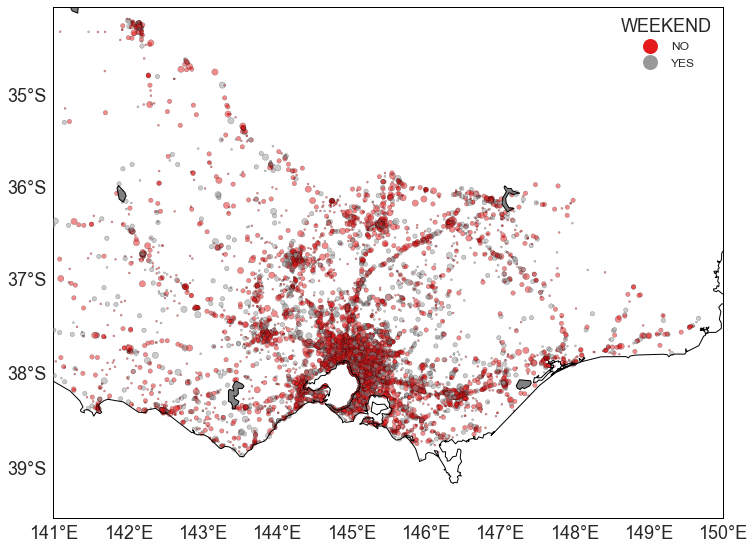

In [464]:
sns.set_style('white')
fig = plt.figure(figsize=(12, 12))

ax = plt.subplot(111)
vic_map = victoria_map(ax)
plot_feature2x(vic_map, roads, "WEEKEND", "SEVERITY", fontsize=12)

I've chosen to take the sum of cars involved rather than the mean to help identify the peaks during the morning and evening rush-hour periods. It does highlight that a possible reason for the higher number of accidents during these periods is because there are more cars on the road at these times (by virtue of more cars being involved per accident). 

### Recommendation

Because the number of accidents is highest during the morning and evening rush-hour periods, a suggested course of action would be to encourage people to use public transport as an alternative to driving, thereby reducing the density of cars on the road. The state transport authority could: offer more accessible public transport, increase the availability of services, create more efficient time-tables, and expand the public transport network through a greater investment in infrastructure. For local governments pressure could be taken off the school zone areas by increasing the number of school bus services, improving routes to be more accessible to some families, or encouraging car pool initiatives.

## What role do the road conditions have on the rate of accidents?

Let's look at under what conditions roads accidents have the highest incidence over the 2 year period. Again we are just summing the number of rows in the dataset and ordering them based on the road geometry.

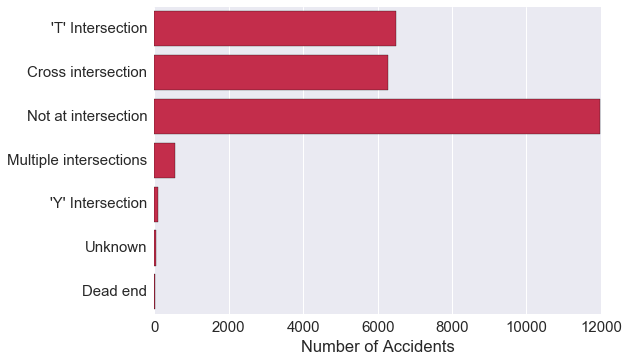

In [117]:
sns.set(font_scale=1.5)
sns.countplot(y="ROAD_GEOMETRY_DESC", data=roads, color='crimson')
sns.axlabel('Number of Accidents', '')

We can immediately see that three of the road geometries experience a large number of accidents over the two year period. We can investigate this further by looking at the total number of accidents by severity for each road geometry, separated by metropolitan and regional areas.

*Because three of these features have relatively low total accidents, I'm going to only work with those road geometries that have a number of accidents greater than 100 over the 2-year period. This will help with the data viz below.*

In [134]:
geom_ncount = roads.ROAD_GEOMETRY_DESC.value_counts()
geom_cut = geom_ncount.iloc[geom_ncount.values > 100].index
print(geom_ncount)

Not at intersection       11989
'T' Intersection           6505
Cross intersection         6287
Multiple intersections      552
'Y' Intersection             94
Unknown                      53
Dead end                      4
Name: ROAD_GEOMETRY_DESC, dtype: int64


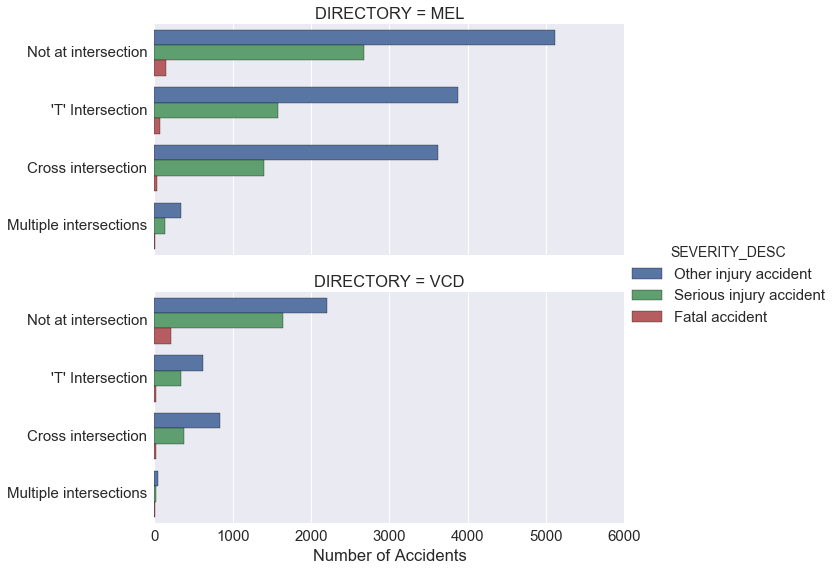

In [135]:
plt.figure(figsize=(12, 12));

sns.set(font_scale=1.5);
g = sns.factorplot(y="ROAD_GEOMETRY_DESC", row="DIRECTORY", hue='SEVERITY_DESC', 
                   kind='count', data=roads, aspect=2.5, order=geom_cut);
g.set_axis_labels('Number of Accidents', '');

Both metropolitan and country regions tend to show most accidents are occurring on *straight* roads, with T- and Cross intersections being of a similar magnitude. Other injury accidents still make up the majority in almost all cases, however for country regions, serious injury accidents are relatively closer in number to other injury accidents. This could be due to the fact that country regions have a greater prevalence of straight roads, with road intersections of various types being more common in metropolitan regions.

However this doesn't tell us what is causing the accidents in these cases, but we can look at that now by including the DCA code description.

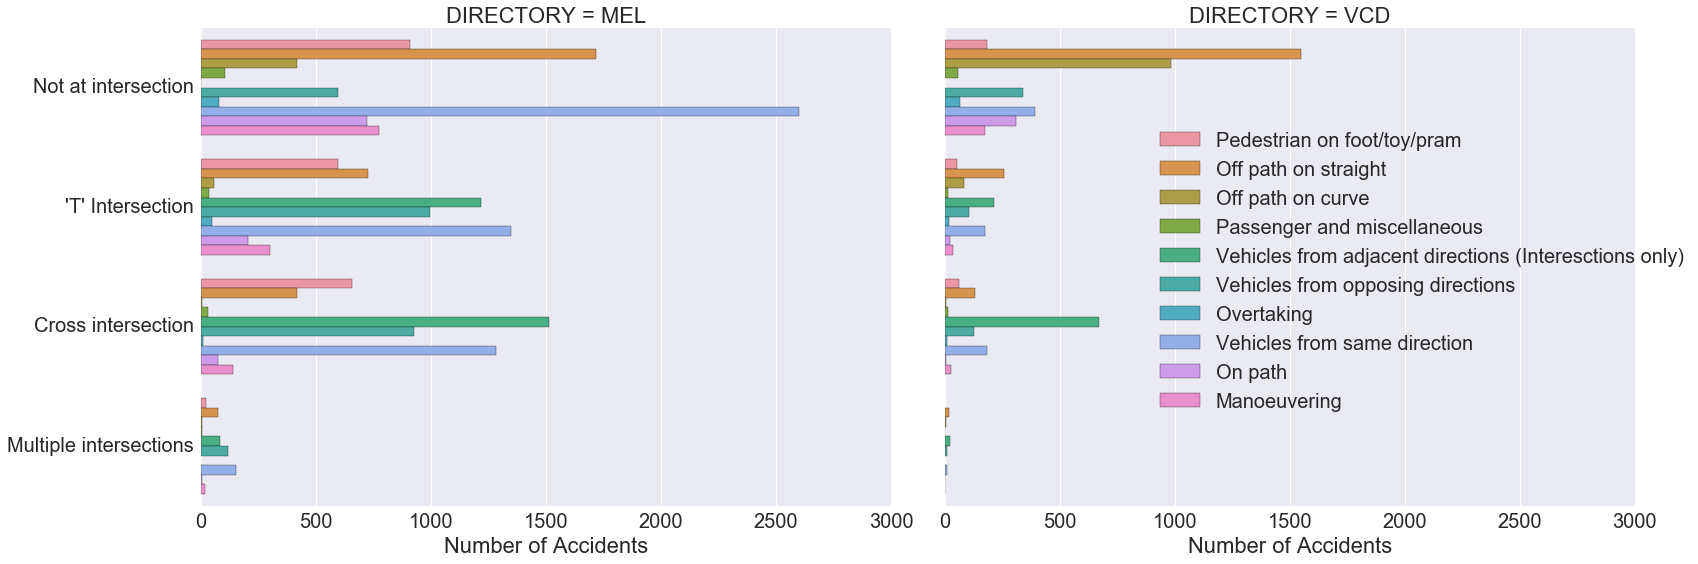

In [182]:
plt.figure(figsize=(12, 28));

sns.set(font_scale=2);
g = sns.factorplot(y="ROAD_GEOMETRY_DESC", col="DIRECTORY", hue='DCA_CODE_TYPE', 
                   kind='count', data=roads, aspect=1.5, size=8, order=geom_cut,
                  legend=False);
g.set_axis_labels('Number of Accidents', '');
plt.legend(bbox_to_anchor=(.3, 0.8), loc=2, borderaxespad=0.);

There are distinct differences between both regions in the types of accidents happening for each road geometry. The only commonalities that one can distinguish is that for straight roads, most accidents have occured as a result of deviating from a straight path, which might suggest fatigue at the wheel. This is actually the highest cause for accidents in country victoria followed by a similar occurence of curved roads - in both cases the driver is not conscious of his path. Surpisingly this is also a major cause in the metropolitan areas. Curved roads don't appear to be as big a cause, but metropolitan road systems are more gridded anyway so this the likely reason for that difference. The other commonality is accidents occurring at cross intersections, which is likely due to vehicles turning right without giving way safely to oncoming traffic. Or merging onto a main road from a side road under similar circumstances - the conditions were not safe to merge with traffic.

The big cause in the metropolitan region though is vehicles travelling along the same path, and one would assume this is likely a cause of driver negligence - not overtaking safely, not maintaining a safe distance with the vehicle in front, blindspots and changing lanes, etc. Given that drivers can be negligent regardless of the situation, the fact that this has a large count across all road geometries is not surprising.

Total number of people killed over the period: 563


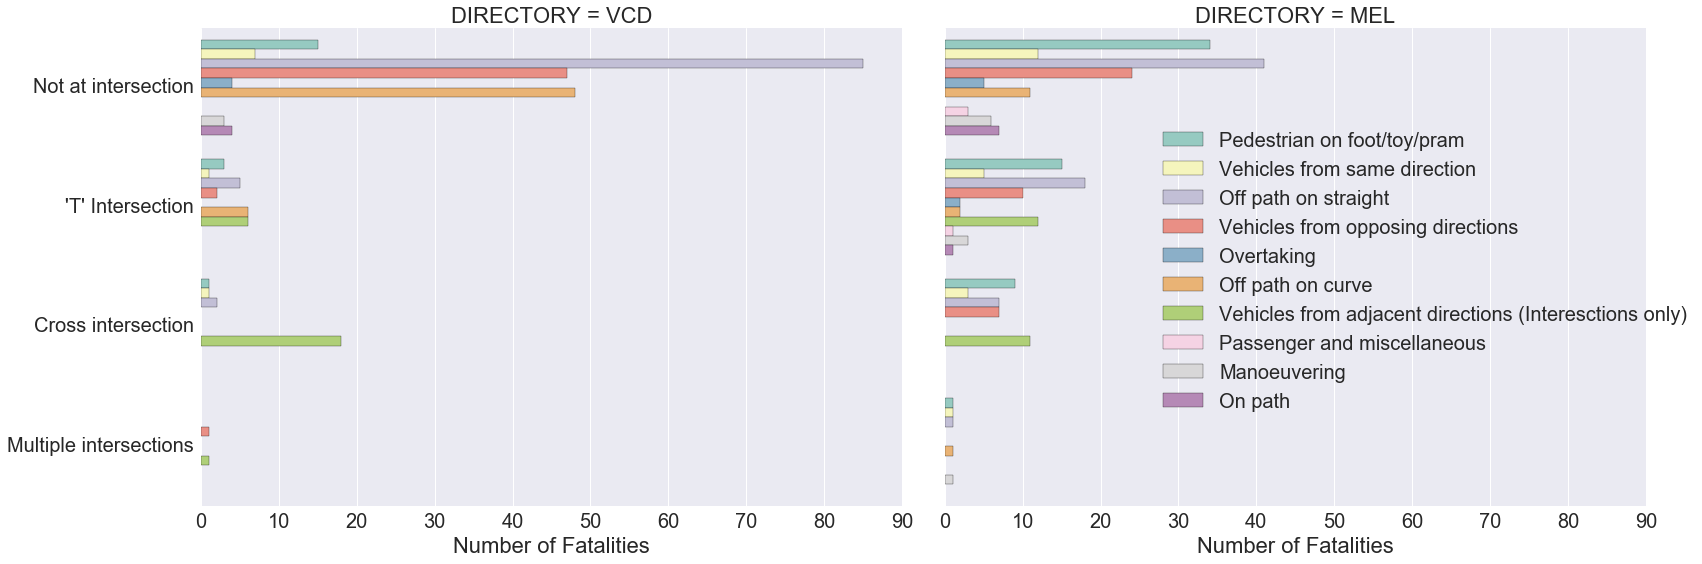

In [204]:
plt.figure(figsize=(12, 28));

sns.set(font_scale=2);
g = sns.factorplot(y="ROAD_GEOMETRY_DESC", col="DIRECTORY", hue='DCA_CODE_TYPE', 
                   kind='count', data=roads[roads['SEVERITY']==1], aspect=1.5, size=8, 
                   legend=False, palette='Set3');
g.set_axis_labels('Number of Fatalities', '');
plt.legend(bbox_to_anchor=(.3, 0.8), loc=2, borderaxespad=0.);
print("Total number of people killed over the period: {0}".format(roads.NP_KILLED.sum()))


**WARNING: Directory headers swapped around**

Finally we can quickly look at the consequences of road accidents to see which types at the different road geometries are major causes for death. In country Victoria, the majority of deaths are occuring on straight roads, and are either vehicle-to-vehicle or the vehicle deviating from its path; likely through driver fatigue or careless driving.

In metropolitan regions, again most fatal accidents are due to the vehicle deviating from its path, but also due to collisions with pedestrians.

### Recomendation

The data suggests different causes for accidents among rural and metropolitan regions.

For rural regions a large proportion of accidents are occuring due to vehicles deviating from their set path and likely colliding with an object adjacent to the road. There is not enough information to say why the vehicles are deviating from their path, but driver fatigue could be a likely cause or loss of control through excessive speed. Government advertising campaigns that raise awareness of driver fatigue could help reduce the number of accidents in rural areas. This would similarly be effective in metropolitan areas where the issues is also prevalent. To remediate accidents on curved roads, a greater number of safety barriers could be installed as well as signs alerting drivers to difficult bends. A joint initiative between local and state governments could help lower the burdern of cost on local councils in installing such infrastructure.

To reduce accidents that occur between vehicles travelling in the same direction and those at cross-paths at intersections a number of suggestions can be made. For vehicles travelling along the same path, better signing of the roadways would help drivers make more confident decisions about their travel path (as opposed to last-minute ones, e.g. changing lanes at the last minute to make a turn-off). Intersections that have a high prevalence of accidents should also be reviewed to have traffic lights with green-arrows, particularly if visibility is poor. If traffic lights are not an option, these intersections should have **No-Right-Turn** signs installed to force drivers to use alternative but safer paths to their destination.

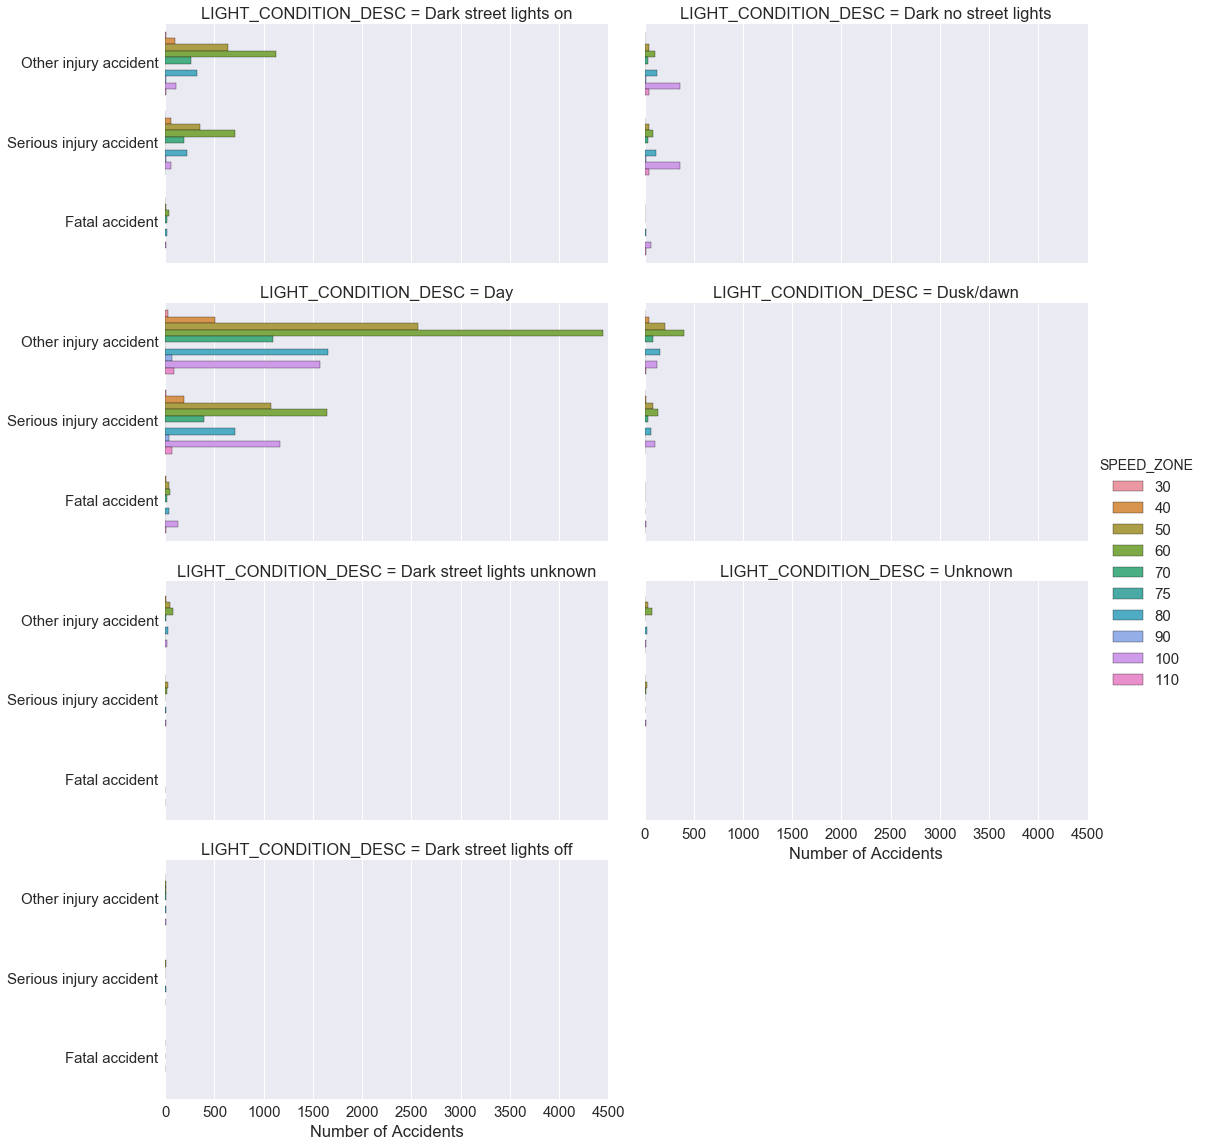

In [49]:
plt.figure(figsize=(12, 12));

sns.set(font_scale=1.5);
g = sns.factorplot(y="SEVERITY_DESC", col="LIGHT_CONDITION_DESC", hue='SPEED_ZONE', 
               kind='count', data=roads, col_wrap=2, aspect=2);
g.set_axis_labels('Number of Accidents', '');

Here we can see that majority of accidents are occuring in the 50-60 km/h speed zones, followed by a large number of accidents occuring in the 90-100 km/h zones. This is bi-modal pattern in the speed-zone binning is likely the result of the metropolitan and regional average speed zones - the influence of speed will be explored next. While the distribution of accidents is similar for almost all conditions, it is noticebly different for **dark no street lights**, where accidents have a high prevalance of occuring in the 90-100 km/h speed zones.

## Using a Random Forest Classifier to build a probabilistic model of accident severity

In [533]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

We start by doing some data munging, a bit of cleaning, etc. Because sklearn does not handle categorical data, we will need to transform those columns to dummy variables; including the severity column, which has information we are trying to predict.

In [ ]:
roads_ml = roads.dropna()

roads_ml['SPEED_ZONE2'] = roads_ml['SPEED_ZONE'].apply(str) #.values
roads_ml['WEEKEND_BIN'] = roads_ml['WEEKEND'].map( {'NO': 0, 'YES': 1} ).astype(int)
roads_ml['LOCALS_BIN'] = roads_ml['LOCALS_INVOLVED'].map( {'N': 0, 'Y': 1} ).astype(int)

targets = pd.get_dummies(roads_ml['SEVERITY'], prefix='Sev')
feature_list = ['ROAD_GEOMETRY_DESC', 'LOCALS_BIN', 'SPEED_ZONE', 'LIGHT_CONDITION_DESC', \
                'WEEKEND_BIN', 'REGION_NAME', 'NO_OF_VEHICLES']
data_x = pd.get_dummies(roads_ml[feature_list])
data_x.shape

#### First we need split the data between training and testing sets, and then determine the hyper parameters for the Random Forest model

In [654]:
params = { \
        #"max_depth": [3, None], \
        "n_estimators": [5, 10, 20, 100, 200], \
        #"min_samples_split": [1, 3, 10], \
        "min_samples_leaf": [1, 3, 10], \
        "max_features": [27], \
        }
sqrtfeat = np.sqrt(X_test.shape[1])

grid_test = { #"n_estimators"      : [1000, 2500, 5000],
               "n_estimators"      : [100, 500, 1000],
               #"criterion"         : ["gini", "entropy"],
               #"max_features"      : [sqrtfeat-1, sqrtfeat, sqrtfeat+1],
               "max_features"      : [X_test.shape[1]],
               "max_depth"         : [5, 10, 25],
               "min_samples_split" : [2, 5, 10] }

regmod_p = make_pipeline(StandardScaler(), RandomForestClassifier())

param_grid = {'{0}__{1}'.format(regmod_p.steps[-1][0], parkey): pardat \
                 for (parkey, pardat) in grid_test.items()}
print(param_grid)
# create a learner
mod_clf = GridSearchCV(estimator=regmod_p, param_grid=param_grid, cv=5, n_jobs=-1)

{'randomforestclassifier__max_features': [24], 'randomforestclassifier__min_samples_split': [2, 5, 10], 'randomforestclassifier__max_depth': [5, 10, 25], 'randomforestclassifier__n_estimators': [100, 500, 1000]}


First we can build a classifer to determine the binary outcome of a fatality **SEVERITY == 1**

In [613]:
X_train, X_test, y_train, y_test = train_test_split(data_x, targets['Sev_1'], test_size=0.66, random_state=42)

In [615]:
mod_clf.fit(X_train.values, y_train.values);
print(mod_clf.score(X_test.values, y_test.values))
print(mod_clf.best_params_)

Having trained the model we can now look at the what are the most important features in predicting a fatality

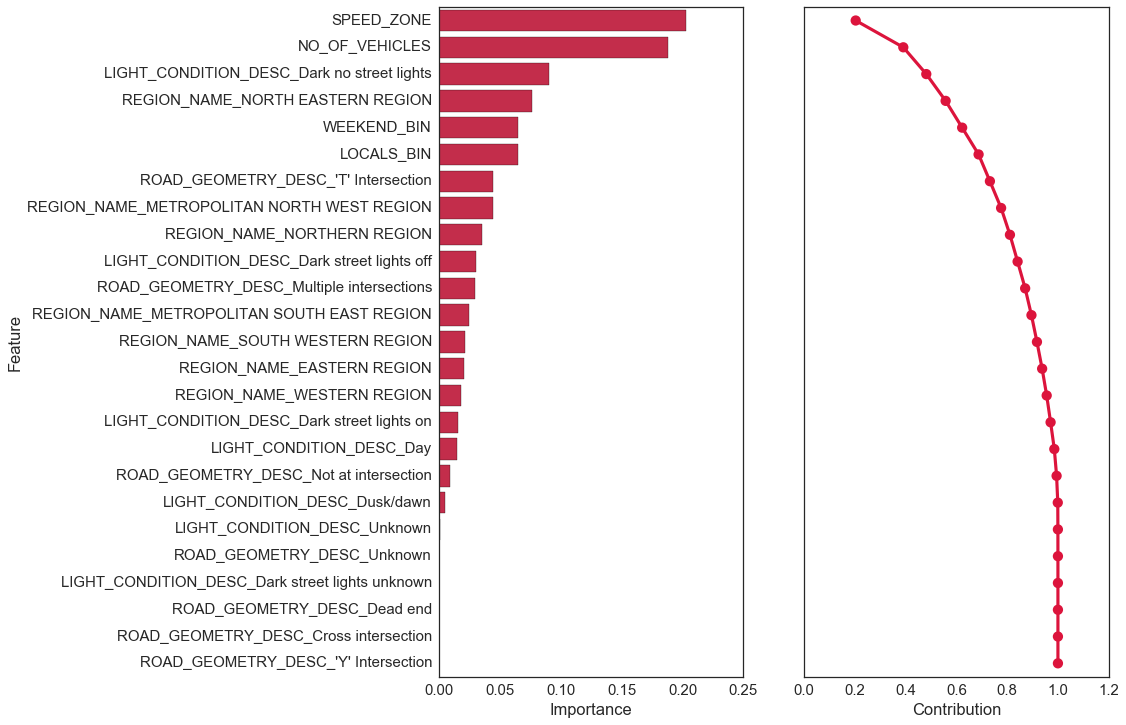

In [619]:
mod_clf2 = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=25, min_samples_split=5)
mod_clf2.fit(X_train.values, y_train.values);

plt.figure(figsize=(12, 12));

feat_table = pd.DataFrame({'Feature':X_train.columns, 'Importance':mod_clf2.feature_importances_})
feat_table.sort_values('Importance', ascending=False, inplace=True)
feat_table['Cumulative'] = feat_table.Importance.cumsum()

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
g1 = sns.barplot(y='Feature', x='Importance', data=feat_table, color='crimson', ax=ax1)
g1.set(xlabel='Importance')
g2 = sns.pointplot(y='Feature', x='Cumulative', data=feat_table, color='crimson', ax=ax2)
g2.set(yticklabels=[])
g2.set(ylabel='')
g2.set(xlabel='Contribution')


We can verify how good the model by plotting the ROC and determining the AUC - we want it be to going towards 1.0

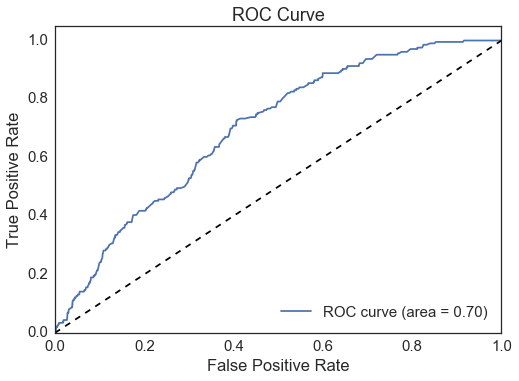

In [620]:
# False-positive and true-positive rates to build an ROC
fpr, tpr, _ = roc_curve(y_test.values, mod_clf.predict_proba(X_test)[:,1])
# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Severity 1')
plt.legend(loc="lower right")

Build a classifer to determine the binary outcome of a serious injury **SEVERITY == 2**

In [655]:
X_train, X_test, y_train, y_test = train_test_split(data_x, targets['Sev_2'], test_size=0.66, random_state=42)

In [656]:
mod_clf.fit(X_train.values, y_train.values);
print(mod_clf.score(X_test.values, y_test.values))
print(mod_clf.best_params_)

0.632540356839
{'randomforestclassifier__max_features': 24, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 500}


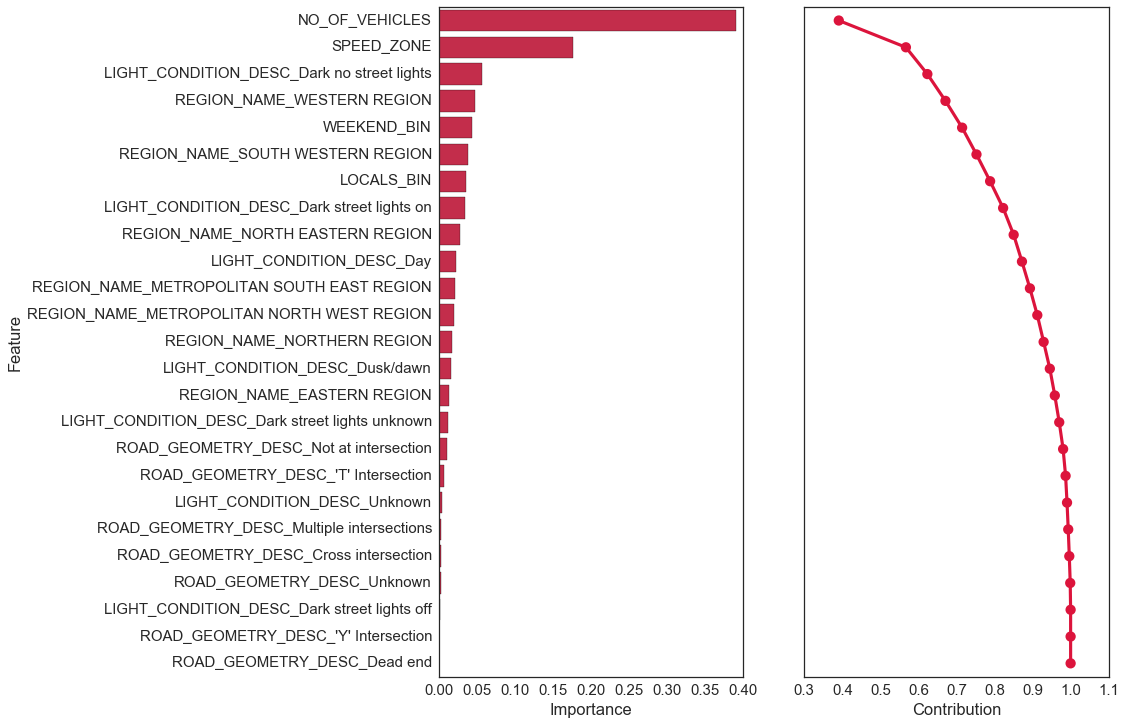

In [657]:
mod_clf2 = RandomForestClassifier(n_estimators=500, max_depth=5, max_features=24, min_samples_split=5)
mod_clf2.fit(X_train.values, y_train.values);

plt.figure(figsize=(12, 12));

feat_table = pd.DataFrame({'Feature':X_train.columns, 'Importance':mod_clf2.feature_importances_})
feat_table.sort_values('Importance', ascending=False, inplace=True)
feat_table['Cumulative'] = feat_table.Importance.cumsum()

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
g1 = sns.barplot(y='Feature', x='Importance', data=feat_table, color='crimson', ax=ax1)
g1.set(xlabel='Importance')
g2 = sns.pointplot(y='Feature', x='Cumulative', data=feat_table, color='crimson', ax=ax2)
g2.set(yticklabels=[])
g2.set(ylabel='')
g2.set(xlabel='Contribution')

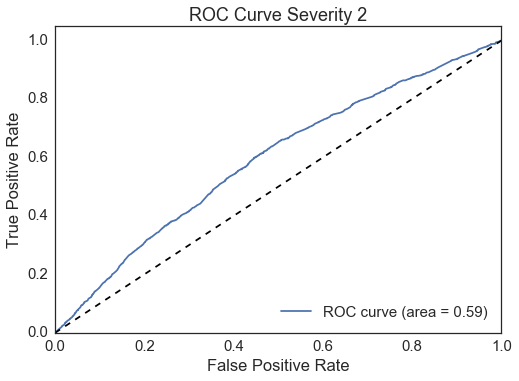

In [658]:
# False-positive and true-positive rates to build an ROC
fpr, tpr, _ = roc_curve(y_test.values, mod_clf.predict_proba(X_test)[:,1])
# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Severity 2')
plt.legend(loc="lower right")

FINALY, build a classifer to determine the binary outcome of the *other* injury category:  **SEVERITY == 3**

In [664]:
X_train, X_test, y_train, y_test = train_test_split(data_x, targets['Sev_3'], test_size=0.66, random_state=42)

In [665]:
mod_clf.fit(X_train.values, y_train.values);
print(mod_clf.score(X_test.values, y_test.values))
print(mod_clf.best_params_)

0.61214953271
{'randomforestclassifier__max_features': 24, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 500}


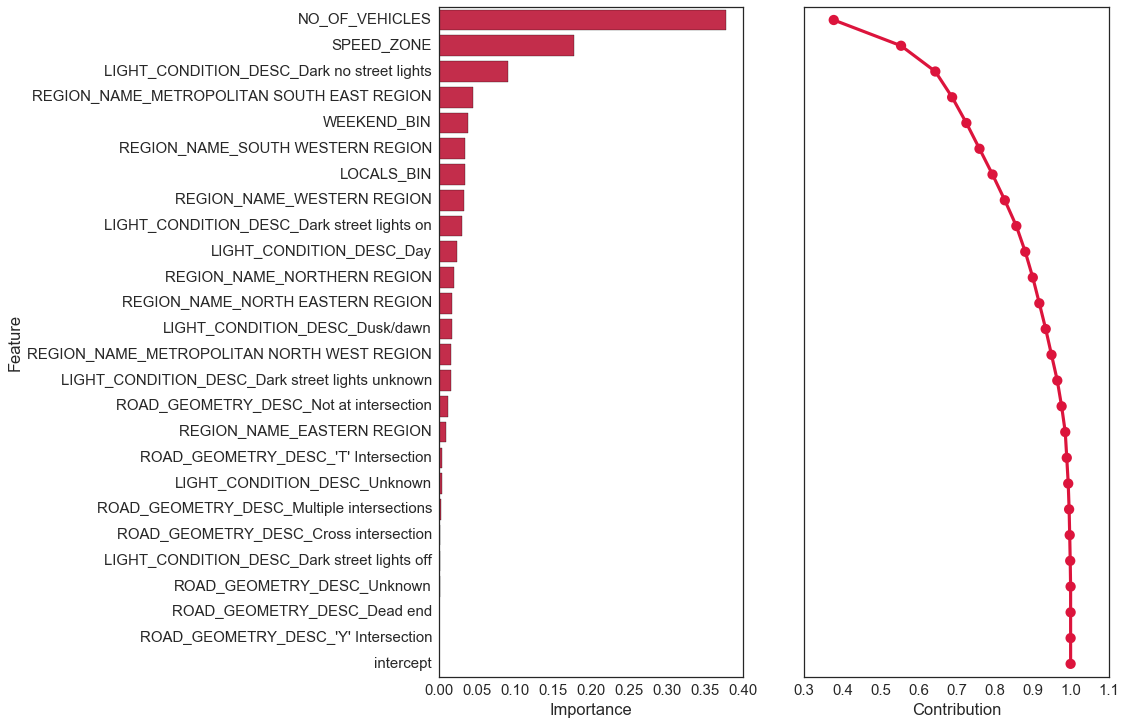

In [666]:
mod_clf2 = RandomForestClassifier(n_estimators=500, max_depth=5, max_features=24, min_samples_split=2)
mod_clf2.fit(X_train.values, y_train.values);

plt.figure(figsize=(12, 12));

feat_table = pd.DataFrame({'Feature':X_train.columns, 'Importance':mod_clf2.feature_importances_})
feat_table.sort_values('Importance', ascending=False, inplace=True)
feat_table['Cumulative'] = feat_table.Importance.cumsum()

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
g1 = sns.barplot(y='Feature', x='Importance', data=feat_table, color='crimson', ax=ax1)
g1.set(xlabel='Importance')
g2 = sns.pointplot(y='Feature', x='Cumulative', data=feat_table, color='crimson', ax=ax2)
g2.set(yticklabels=[])
g2.set(ylabel='')
g2.set(xlabel='Contribution')

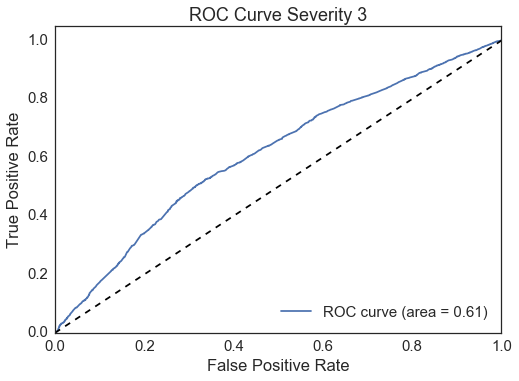

In [667]:
# False-positive and true-positive rates to build an ROC
fpr, tpr, _ = roc_curve(y_test.values, mod_clf.predict_proba(X_test)[:,1])
# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Severity 3')
plt.legend(loc="lower right")

### Sanity check with Logit model - I don't think this is as informative

This is just to check if the two methods agree on what the features of importance are, but they are not directly comparable. Given the amount of features in the dataset, the logit model has problems with MLE convergence.

**SEVERITY == 1**

In [660]:
import statsmodels.api as sm

data_x['intercept'] = [1.0]*len(data_x)

# to include light predictors
light_feat = [c for c in data_x.columns if re.search('^LIGHT_.*', c)]

sel_feat = ['LOCALS_BIN', 'NO_OF_VEHICLES', 'SPEED_ZONE', 'WEEKEND_BIN', 'intercept']
# fit the model
logit = sm.Logit(targets['Sev_1'], data_x[light_feat[:2]+sel_feat])
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.126001
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Sev_1   No. Observations:                10699
Model:                          Logit   Df Residuals:                    10692
Method:                           MLE   Df Model:                            6
Date:                Sun, 26 Jun 2016   Pseudo R-squ.:                 0.05582
Time:                        23:33:22   Log-Likelihood:                -1348.1
converged:                       True   LL-Null:                       -1427.8
                                        LLR p-value:                 7.939e-32
                                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------
LIGHT_CONDITION_DESC_Dark no street lights

**SEVERITY == 2**

In [661]:
# fit the model
logit = sm.Logit(targets['Sev_2'], data_x[light_feat[:2]+sel_feat])
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.642904
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  Sev_2   No. Observations:                10699
Model:                          Logit   Df Residuals:                    10692
Method:                           MLE   Df Model:                            6
Date:                Sun, 26 Jun 2016   Pseudo R-squ.:                 0.01693
Time:                        23:33:28   Log-Likelihood:                -6878.4
converged:                       True   LL-Null:                       -6996.9
                                        LLR p-value:                 2.619e-48
                                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------
LIGHT_CONDITION_DESC_Dark no street lights

**SEVERITY == 3**

In [662]:
# fit the model
logit = sm.Logit(targets['Sev_3'], data_x[light_feat[:2]+sel_feat])
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.652435
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  Sev_3   No. Observations:                10699
Model:                          Logit   Df Residuals:                    10692
Method:                           MLE   Df Model:                            6
Date:                Sun, 26 Jun 2016   Pseudo R-squ.:                 0.02478
Time:                        23:33:55   Log-Likelihood:                -6980.4
converged:                       True   LL-Null:                       -7157.8
                                        LLR p-value:                 1.458e-73
                                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------
LIGHT_CONDITION_DESC_Dark no street lights

## Time-series

In [459]:
roads_region = roads[numeric_cols + ['DIRECTORY']]
roads_tseries = roads_region.groupby('DIRECTORY')
#roads_tseries.resample('M').sum()

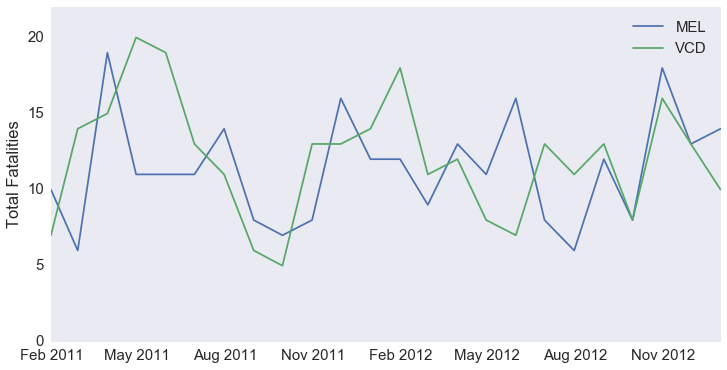

In [462]:
# Plot the time-series
#sns.set_style('white')
fig = plt.figure(figsize=(12, 6))
for reg, data in roads_tseries:
    data_month = data.resample('M').sum()
    ax, = plt.plot_date(data_month.index, data_month['NP_KILLED'], '-', label=reg)
    #plt.axhline(np.mean(data_month['NP_KILLED']), c=ax.get_color(), lw=2)
plt.grid()
plt.ylabel('Total Fatalities')
plt.ylim([0, 22])
plt.legend()
#plt.plot_date()